In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import scienceplots

plt.style.use("science")

SEED = 42

## Load ESC-10 dataset

In [2]:
from sklearn.preprocessing import OneHotEncoder

data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df = df.query("esc10 == True").reset_index()

categories = df["category"].to_numpy()

encoder = OneHotEncoder()
target = encoder.fit_transform(categories.reshape(-1, 1)).toarray()
df["target"] = target.tolist()
df["class"] = df["target"].apply(lambda x: np.argmax(x))

df[["category", "class"]].drop_duplicates().set_index("class").sort_index()

,category
class,
0,chainsaw
1,clock_tick
2,crackling_fire
3,crying_baby
4,dog
5,helicopter
6,rain
7,rooster
8,sea_waves


## Preliminary data analysis

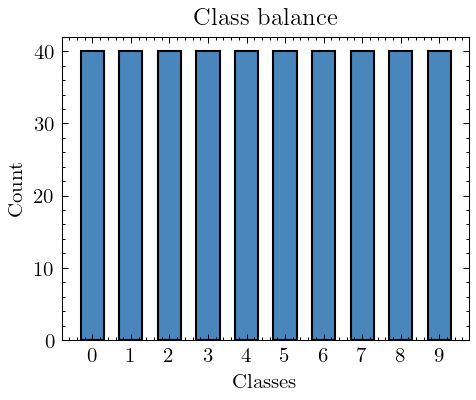

In [3]:
plt.figure(dpi=150)
g = sns.histplot(df, x="class", discrete=True, shrink=0.6)
plt.title("Class balance")
plt.xlabel("Classes")
plt.xticks(np.arange(10))
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "class_balance.png"), dpi=150)
plt.show()

## Feature extraction

In [4]:
import torch
import torchaudio


class myPipeline(torch.nn.Module):
    def __init__(
        self,
        n_mfcc: int = 40,
        sample_rate=44100,
        mtWin=1,
        mtStep=0.5,
        stWin=0.02,
        stStep=0.01,
    ):
        super().__init__()
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.mtWin = np.floor(mtWin * sample_rate).astype(int)
        self.mtStep = np.floor(mtStep * sample_rate).astype(int)
        self.stWin = np.floor(stWin * sample_rate).astype(int)
        self.stStep = np.floor(stStep * sample_rate).astype(int)

        self.resample = torchaudio.transforms.Resample(
            new_freq=self.sample_rate, lowpass_filter_width=128
        )

        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={"n_fft": 2048, "hop_length": 512},
            log_mels=True,
        )

    def stereo2mono(self, waveform: torch.Tensor) -> torch.Tensor:
        if waveform.shape[0] == 2:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        return waveform

    def windowize(self, waveform: torch.Tensor, win: int, step: int) -> torch.Tensor:
        mtWindows = waveform.unfold(1, win, step)
        return mtWindows

    def timeFeatExtraction(self, waveform: torch.Tensor) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        mtWindows = self.windowize(waveform, self.mtWin, self.mtStep)
        mtZCR_mean = torch.zeros(mtWindows.shape[1])
        mtZCR_std = torch.zeros(mtWindows.shape[1])
        energy_mean = torch.zeros(mtWindows.shape[1])
        energy_std = torch.zeros(mtWindows.shape[1])
        energyEntropy_mean = torch.zeros(mtWindows.shape[1])
        energyEntropy_std = torch.zeros(mtWindows.shape[1])
        for i in range(mtWindows.shape[1]):
            mtWindow = mtWindows[:, i, :]
            stWindows = self.windowize(mtWindow, self.stWin, self.stStep)
            zcr = torch.zeros(stWindows.shape[1])
            energy = torch.zeros(stWindows.shape[1])
            energyEntropy = torch.zeros(stWindows.shape[1])
            for j in range(stWindows.shape[1]):
                stWindow = stWindows[:, j, :]
                # Zero Crossing Rate
                zcr[j] = (
                    1
                    / (2 * stWindow.shape[1])
                    * torch.sum(torch.abs(torch.diff(torch.sign(stWindow[0, :]))))
                )

                # Energy
                energy[j] = (1 / (len(stWindow))) * torch.sum(torch.abs(stWindow**2))

                # Energy entropy
                eps = 1e-8
                subFramesLen = 147
                subFrames = stWindow.reshape(1, -1, subFramesLen)
                subFramesEnergy = (
                    1 / subFramesLen * torch.sum(torch.abs(subFrames**2), dim=2)
                )
                subFramesEnergyNorm = subFramesEnergy / (
                    torch.sum(subFramesEnergy) + eps
                )
                energyEntropy[j] = -torch.sum(
                    subFramesEnergyNorm * torch.log2(subFramesEnergyNorm + eps)
                )

            mtZCR_mean[i] = torch.mean(zcr)
            mtZCR_std[i] = torch.std(zcr)
            energy_mean[i] = torch.mean(energy)
            energy_std[i] = torch.std(energy)
            energyEntropy_mean[i] = torch.mean(energyEntropy)
            energyEntropy_std[i] = torch.std(energyEntropy)

        ltZCR_mean = torch.mean(mtZCR_mean).unsqueeze(0)
        ltZCR_std = torch.mean(mtZCR_std).unsqueeze(0)
        ltenergy_mean = torch.mean(energy_mean).unsqueeze(0)
        ltenergy_std = torch.mean(energy_std).unsqueeze(0)
        ltenergyEntropy_mean = torch.mean(energyEntropy_mean).unsqueeze(0)
        ltenergyEntropy_std = torch.mean(energyEntropy_std).unsqueeze(0)

        return (
            ltZCR_mean,
            ltZCR_std,
            ltenergy_mean,
            ltenergy_std,
            ltenergyEntropy_mean,
            ltenergyEntropy_std,
        )

    def normalize(self, waveform: torch.Tensor) -> torch.Tensor:
        rms = torch.sqrt(torch.mean(waveform**2))
        waveform = waveform / rms
        return waveform

    def forward(self, waveform: torch.Tensor, sample_rate) -> torch.Tensor:
        if waveform.shape[0] == 2:
            waveform = self.stereo2mono(waveform)

        if sample_rate != self.sample_rate:
            self.resample.orig_freq = sample_rate
            self.resample(waveform)

        waveform = self.normalize(waveform)
        mfcc = self.mfcc(waveform).mean(dim=2).squeeze(0)
        timeFeatures = self.timeFeatExtraction(waveform)

        features = torch.cat(
            (
                mfcc,
                timeFeatures[0],
                timeFeatures[1],
                timeFeatures[2],
                timeFeatures[3],
                timeFeatures[4],
                timeFeatures[5],
            )
        )
        return features

In [5]:
n_features = 46
feature_extractor = myPipeline()
features = torch.zeros(len(df), n_features)
for i, row in tqdm(df.iterrows()):
    waveform, sample_rate = torchaudio.load(
        os.path.join(data_dir, "audio", row["filename"]), channels_first=True
    )
    features[i] = feature_extractor(waveform, sample_rate)

# Discard first mfcc coefficient
features = features[:, 1:]

400it [00:25, 15.60it/s]


## Dimensionality reduction

### PCA

array([0.24552853, 0.0938661 ])

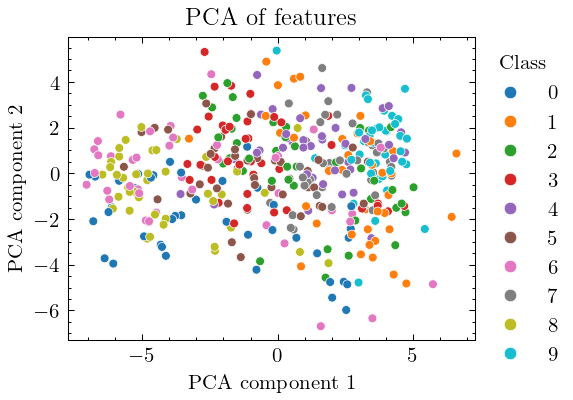

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize Features
scaler = StandardScaler()
features = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
display(pca.explained_variance_ratio_)

# Plot PCA
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Class", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca.png"), dpi=150)
plt.show()

### t-SNE

/Users/filippouslenghi/audio-pattern/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


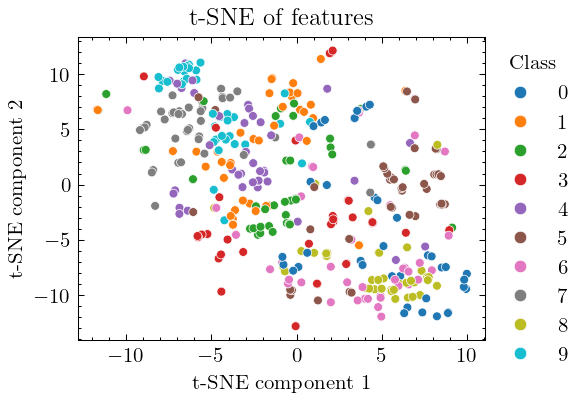

In [7]:
# Apply t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Class", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("t-SNE of features")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "tsne.png"), dpi=150)
plt.show()

## Clustering with k-mean

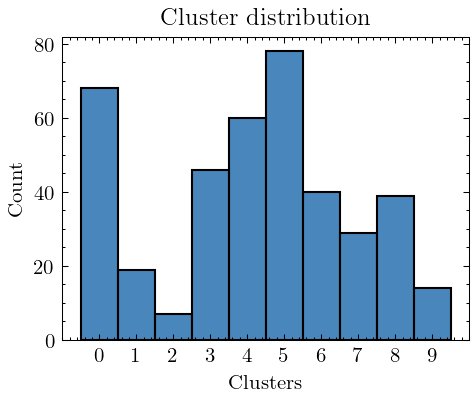

In [8]:
# Apply k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=10,
    init="random",
    n_init=50,
    random_state=SEED,
)
clusters = kmeans.fit_predict(features)

plt.figure(dpi=150)
sns.histplot(
    clusters,
    discrete=True,
)
plt.xticks(np.arange(10))
plt.title("Cluster distribution")
plt.xlabel("Clusters")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "cluster_distribution.png"), dpi=150)
plt.show()

### Plotting

#### PCA

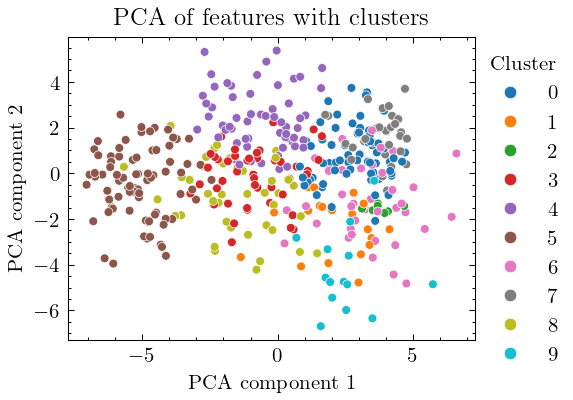

In [9]:
# Plot PCA with clusters
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=clusters,
    palette="tab10",
    legend=True,
    size=0.5,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features with clusters")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca_clusters.png"), dpi=150)
plt.show()

#### t-SNE

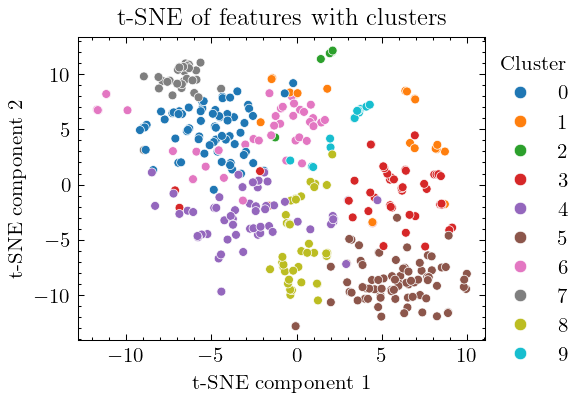

In [10]:
# Plot t-SNE with clusters
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=clusters,
    palette="tab10",
    legend=True,
    size=0.5,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("t-SNE of features with clusters")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "tsne_clusters.png"), dpi=150)
plt.show()

### Evaluating clusters

#### Sorting by clusters

In [11]:
from scipy.spatial import distance_matrix


def similarity_matrix(X):
    dist_matrix = distance_matrix(X, X)
    normalized_dist_matrix = dist_matrix / np.max(dist_matrix)
    similarity_matrix = 1 - normalized_dist_matrix
    return similarity_matrix

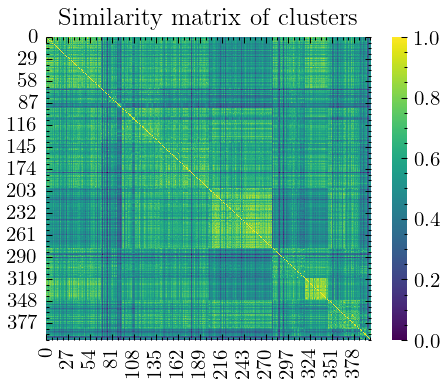

In [12]:
sorted_features = features[np.argsort(clusters)]
sim_matrix = similarity_matrix(sorted_features)
plt.figure(dpi=150)
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similarity matrix of clusters")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "similarity_matrix_clusters.png"), dpi=150)
plt.show()

#### Sorting by class

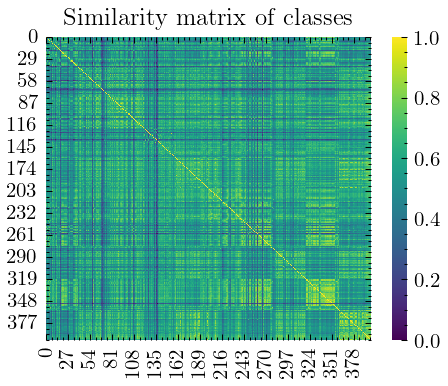

In [13]:
sorted_features = features[np.argsort(df["class"])]
sim_matrix = similarity_matrix(sorted_features)
plt.figure(dpi=150)
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Similarity matrix of classes")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "similarity_matrix_class.png"), dpi=150)
plt.show()

## Classification

### Data split

In [14]:
from sklearn.model_selection import train_test_split

X = features
y = df["class"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

### Dummy classifier

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.10      0.10      0.10        10
           2       0.33      0.30      0.32        10
           3       0.11      0.10      0.11        10
           4       0.20      0.20      0.20        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.07      0.10      0.08        10
           8       0.08      0.10      0.09        10
           9       0.09      0.10      0.10        10

    accuracy                           0.10       100
   macro avg       0.10      0.10      0.10       100
weighted avg       0.10      0.10      0.10       100



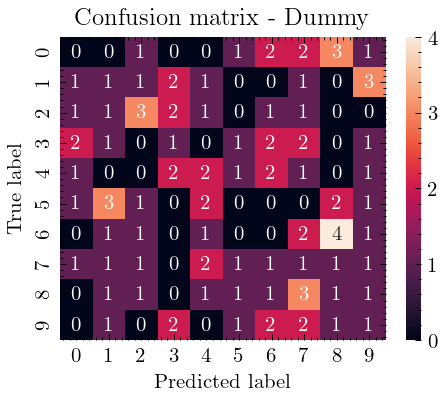

In [15]:
# Create dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="uniform", random_state=SEED)
y_pred = dummy.fit(X_train, y_train).predict(X_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
dummy_acc = round(clf_report["accuracy"], 2)
dummy_f1 = round(clf_report["macro avg"]["f1-score"], 2)
dummy_precision = round(clf_report["macro avg"]["precision"], 2)
dummy_recall = round(clf_report["macro avg"]["recall"], 2)
print(classification_report(y_test, y_pred))


plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.title("Confusion matrix - Dummy")
plt.xlabel("Predicted label")
plt.ylabel("True label")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "confusion_matrix_dummy.png"), dpi=150)
plt.show()

### KNN

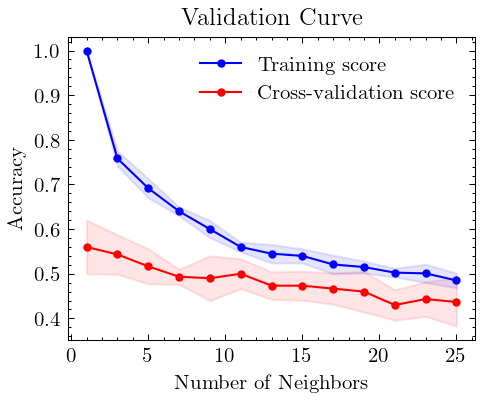

In [16]:
# Train a knn classifier on the features with onevsrest strategy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve

param_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Calculate mean and standard deviation of training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(dpi=150)
plt.plot(
    param_range,
    train_mean,
    label="Training score",
    color="blue",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    label="Cross-validation score",
    color="red",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="red",
)
plt.title("Validation Curve")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.legend(loc="best")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "knn_validation_curve.png"), dpi=150)
plt.show()

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.83      0.50      0.62        10
           2       0.33      0.20      0.25        10
           3       1.00      0.90      0.95        10
           4       0.55      0.60      0.57        10
           5       0.60      0.60      0.60        10
           6       0.38      0.30      0.33        10
           7       1.00      0.80      0.89        10
           8       0.56      1.00      0.71        10
           9       0.36      0.50      0.42        10

    accuracy                           0.60       100
   macro avg       0.62      0.60      0.59       100
weighted avg       0.62      0.60      0.59       100



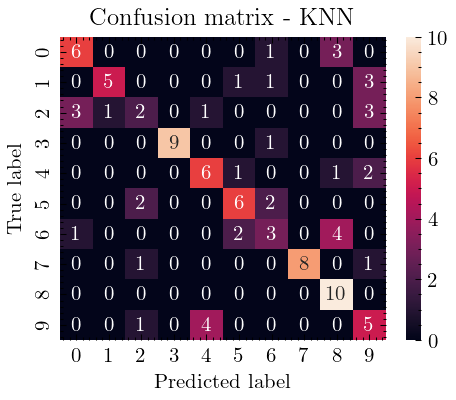

In [17]:
# Train a knn classifier with found hyperparameter
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
knn_acc = round(clf_report["accuracy"], 2)
knn_f1 = round(clf_report["macro avg"]["f1-score"], 2)
knn_precision = round(clf_report["macro avg"]["precision"], 2)
knn_recall = round(clf_report["macro avg"]["recall"], 2)
knn_class_f1 = [round(clf_report[str(c)]["f1-score"], 2) for c in range(0, 10)]
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix - KNN")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "confusion_matrix_knn.png"), dpi=150)
plt.show()

### SVM

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.62      0.50      0.56        10
           2       0.56      0.50      0.53        10
           3       0.91      1.00      0.95        10
           4       0.86      0.60      0.71        10
           5       0.62      0.50      0.56        10
           6       0.29      0.20      0.24        10
           7       1.00      0.90      0.95        10
           8       0.60      0.90      0.72        10
           9       0.64      0.90      0.75        10

    accuracy                           0.68       100
   macro avg       0.68      0.68      0.67       100
weighted avg       0.68      0.68      0.67       100



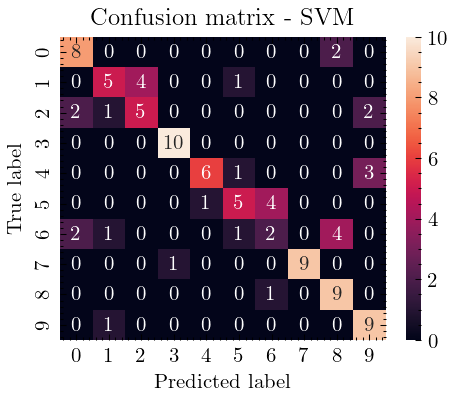

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.01, 0.1, 1, 10, 100],
    "kernel": ["rbf", "poly", "sigmoid"],
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
svm_acc = round(clf_report["accuracy"], 2)
svm_f1 = round(clf_report["macro avg"]["f1-score"], 2)
svm_precision = round(clf_report["macro avg"]["precision"], 2)
svm_recall = round(clf_report["macro avg"]["recall"], 2)
svm_class_f1 = [round(clf_report[str(c)]["f1-score"], 2) for c in range(0, 10)]
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix - SVM")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "confusion_matrix_svm.png"), dpi=150)
plt.show()

### Simple MLP

Best parameters: {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (80, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.60      0.60      0.60        10
           2       0.75      0.90      0.82        10
           3       0.90      0.90      0.90        10
           4       0.50      0.30      0.38        10
           5       0.86      0.60      0.71        10
           6       0.57      0.40      0.47        10
           7       0.82      0.90      0.86        10
           8       0.56      0.90      0.69        10
           9       0.78      0.70      0.74        10

    accuracy                           0.69       100
   macro avg       0.69      0.69      0.68       100
weighted avg       0.69      0.69      0.68       100



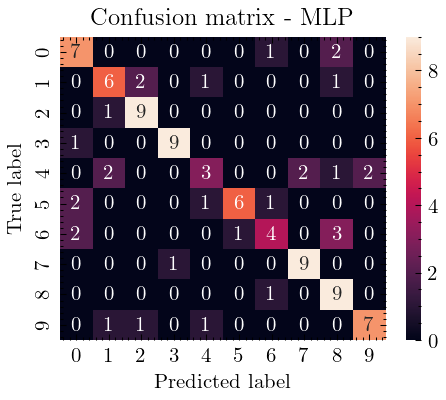

In [19]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    "hidden_layer_sizes": [(80), (80, 50), (80, 50, 50)],
    "learning_rate_init": [0.01, 0.001],
    "solver": ["adam", "sgd"],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],
    "batch_size": [32, 64],
}

clf = MLPClassifier(
    max_iter=5000,
    n_iter_no_change=10,
    random_state=SEED,
)

grid_search = GridSearchCV(
    clf, param_grid, refit=True, cv=5, scoring="accuracy", n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
pd.DataFrame(grid_search.cv_results_).to_csv("mlp_grid_search.csv", index=False)

y_pred = grid_search.predict(X_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
mlp_acc = round(clf_report["accuracy"], 2)
mlp_f1 = round(clf_report["macro avg"]["f1-score"], 2)
mlp_precision = round(clf_report["macro avg"]["precision"], 2)
mlp_recall = round(clf_report["macro avg"]["recall"], 2)
mlp_class_f1 = [round(clf_report[str(c)]["f1-score"], 2) for c in range(0, 10)]
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix - MLP")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "confusion_matrix_mlp.png"), dpi=150)
plt.show()

### Random Forest

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.83      0.50      0.62        10
           2       0.70      0.70      0.70        10
           3       0.90      0.90      0.90        10
           4       0.73      0.80      0.76        10
           5       0.62      0.50      0.56        10
           6       0.60      0.60      0.60        10
           7       1.00      0.90      0.95        10
           8       0.83      1.00      0.91        10
           9       0.71      1.00      0.83        10

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.77       100
weighted avg       0.78      0.78      0.77       100



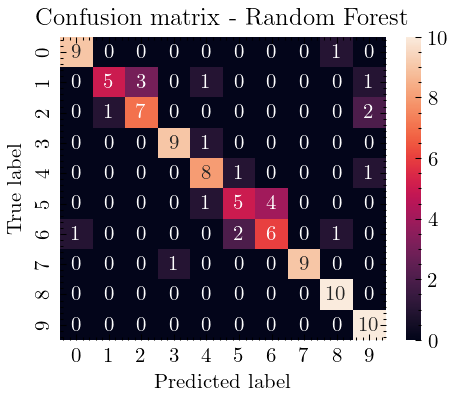

In [20]:
# Apply random forest classifier
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [10, 20, 30, 40, 50],
    "criterion": ["gini", "entropy"],
}

clf = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(clf, param_grid, refit=True, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
clf_report = classification_report(y_test, y_pred, output_dict=True)
rf_acc = round(clf_report["accuracy"], 2)
rf_f1 = round(clf_report["macro avg"]["f1-score"], 2)
rf_precision = round(clf_report["macro avg"]["precision"], 2)
rf_recall = round(clf_report["macro avg"]["recall"], 2)
rf_class_f1 = [round(clf_report[str(c)]["f1-score"], 2) for c in range(0, 10)]
print(classification_report(y_test, y_pred))

plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix - Random Forest")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "confusion_matrix_rf.png"), dpi=150)
plt.show()

## Results

In [21]:
results = {
    "Model": ["Dummy", "KNN", "SVM", "MLP", "Random Forest"],
    "Accuracy": [dummy_acc, knn_acc, svm_acc, mlp_acc, rf_acc],
    "Precision": [
        dummy_precision,
        knn_precision,
        svm_precision,
        mlp_precision,
        rf_precision,
    ],
    "Recall": [dummy_recall, knn_recall, svm_recall, mlp_recall, rf_recall],
    "F1-score": [dummy_f1, knn_f1, svm_f1, mlp_f1, rf_f1],
}

results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)
results_df

,Model,Accuracy,Precision,Recall,F1-score
0,Dummy,0.10,0.10,0.10,0.10
1,KNN,0.60,0.62,0.60,0.59
2,SVM,0.68,0.68,0.68,0.67
3,MLP,0.69,0.69,0.69,0.68
4,Random Forest,0.78,0.78,0.78,0.77


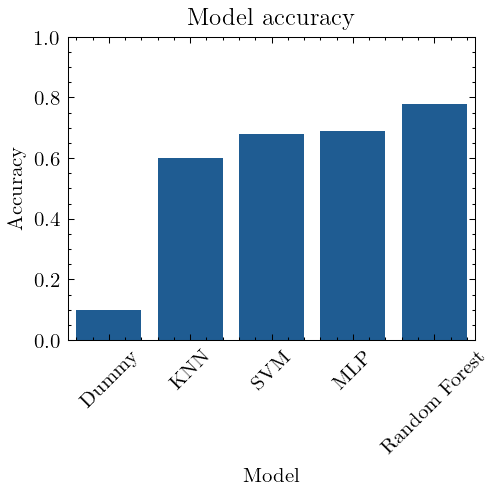

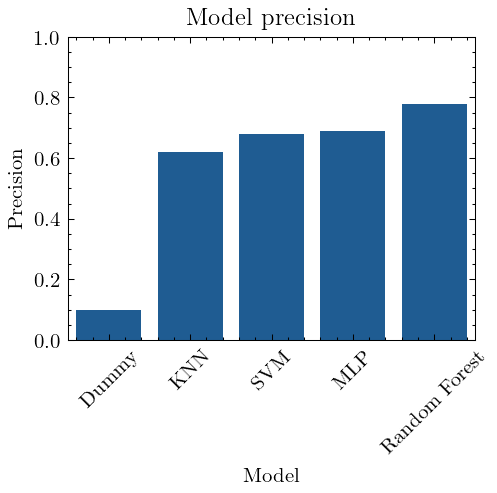

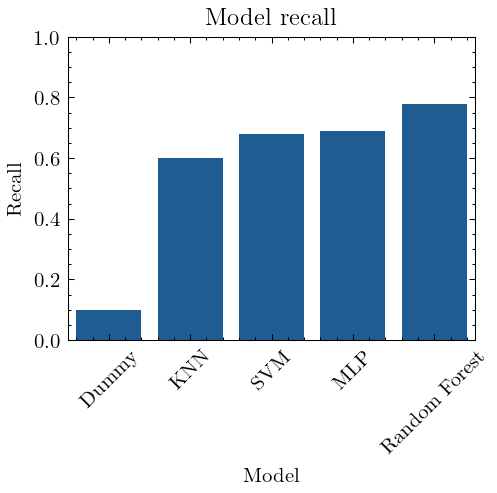

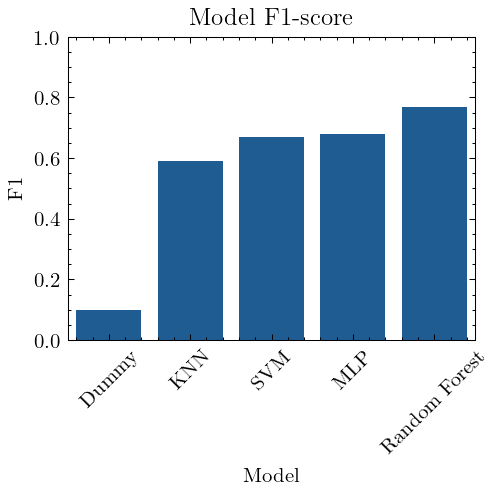

In [22]:
# Plot results
plt.figure(dpi=150)
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "model_accuracy.png"), dpi=150)
plt.show()

plt.figure(dpi=150)
sns.barplot(x="Model", y="Precision", data=results_df)
plt.title("Model precision")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.xticks(rotation=45)
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "model_precision.png"), dpi=150)
plt.show()

plt.figure(dpi=150)
sns.barplot(x="Model", y="Recall", data=results_df)
plt.title("Model recall")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.xticks(rotation=45)
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "model_recall.png"), dpi=150)
plt.show()

plt.figure(dpi=150)
sns.barplot(x="Model", y="F1-score", data=results_df)
plt.title("Model F1-score")
plt.ylabel("F1")
plt.ylim(0, 1)
plt.xticks(rotation=45)
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "model_f1.png"), dpi=150)
plt.show()

### Looking at each class

In [23]:
data = {
    "Model": [
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "KNN",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "SVM",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "MLP",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
        "Random Forest",
    ],
    "Class": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 4,
    "F1-score": [
        *knn_class_f1,
        *svm_class_f1,
        *mlp_class_f1,
        *rf_class_f1,
    ],
}

df = pd.DataFrame(data)
df.to_csv("class_results.csv", index=False)
df.head()

,Model,Class,F1-score
0,KNN,0,0.60
1,KNN,1,0.62
2,KNN,2,0.25
3,KNN,3,0.95
4,KNN,4,0.57


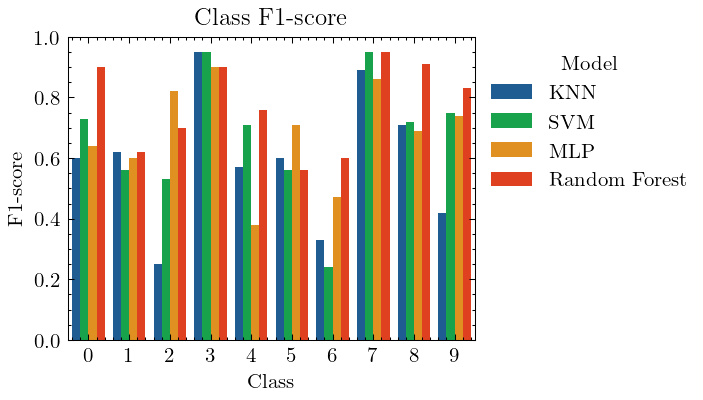

In [24]:
# Plot class results
plt.figure(dpi=150)
ax = sns.barplot(x="Class", y="F1-score", hue="Model", data=df)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, title="Model", loc="upper right", bbox_to_anchor=(1.57, 1))
plt.title("Class F1-score")
plt.ylabel("F1-score")
plt.ylim(0, 1)
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "class_f1.png"), dpi=150)
plt.show()